## Independent Study Final Project


The aim of this project is to demonstrate a link between the real information content and the Bit Grooming compression level that is applied to a spatial dataset. In addition, we want to investigate how the real information performs as a metric to detect compression artifacts compared to an existing metric, the DSSIM. For instance, is there a specific real information threshold that can indicate two datasets look visually similar, as in the DSSIM? Is the real information content more effective at capturing certain types of compression induced errors in the data, such as noise?

In this repository, the files /data/test_set/daily_dssims.csv and /data/test_set/monthly_dssims.csv include a list of the DSSIMS for each climate variable at each time slice, and the files /data/test_set/daily_zfp_bg_sz_comp_slices.csv and /data/test_set/monthly_zfp_bg_sz_comp_slices.csv include a column ("zfp_level") that provides a list of the optimal compression level for each time slice based on a DSSIM cutoff threshold of 0.9995, which may be useful for comparison with the real information content.

In [1]:
# Add ldcpy root to system path
import sys
import struct
from math import log2

import astropy
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '/Users/alex/git/ldcpy')

# Import ldcpy package
# Autoreloads package everytime the package is called, so changes to code will be reflected in the notebook if the above sys.path.insert(...) line is uncommented.
%load_ext autoreload
%autoreload 2

# suppress all of the divide by zero warnings
import warnings

warnings.filterwarnings("ignore")
import ldcpy

import time

# display the plots in this notebook
%matplotlib inline

In [2]:
import h5py
# ZFP filter id is 32013
print("ZFP plugin available?", h5py.h5z.filter_avail(32013))


ZFP plugin available? False


In [3]:
from collections import defaultdict
import os
import h5py
HAS_ZFP = h5py.h5z.filter_avail(32013)


cols_monthly = {}
cols_daily = {}
sets = {}
levels = {}
data_path = "/Users/alex/git/ldcpy/data/cam-fv"


climate_var_arrays = {}
data_sets = [
    "orig.PRECT.60days.nc",
    "zfp1e-1.TS.100days.nc",
    "zfp1e-7.PRECT.60days.nc",
    "orig.TS.100days.nc",
    "zfp1e-11.PRECT.60days.nc",
    "zfp1e-9.PRECT.60days.nc",
]
safe_sets = data_sets if HAS_ZFP else [fn for fn in data_sets if fn.startswith("orig.")]


by_var = defaultdict(list)
for fn in safe_sets:
    label, var, *_ = fn.split(".")
    by_var[var].append(fn)

daily_variables = sorted(by_var.keys())

for variable in daily_variables:
    files = [os.path.join(data_path, fn) for fn in by_var[variable]]
    labels = [fn.split(".")[0] for fn in by_var[variable]]  # e.g., "orig", "zfp1e-7", ...

    # Optional: put 'orig' first for nicer ordering
    order = sorted(range(len(labels)), key=lambda i: (labels[i] != "orig", labels[i]))
    files  = [files[i]  for i in order]
    labels = [labels[i] for i in order]

    cols_daily[variable] = ldcpy.open_datasets(
        "cam-fv",
        [variable],
        files,          # pass the full file paths
        labels,         # human-readable labels for each set
        chunks={"time": 700},
    )
    
    # this is specifically for daily variables, see climate_var_arrays_monthly below for the monthly variables
    climate_var_arrays[variable] = np.array(cols_daily[variable][variable].isel(time=0).values)

dataset size in GB 0.01

dataset size in GB 0.02



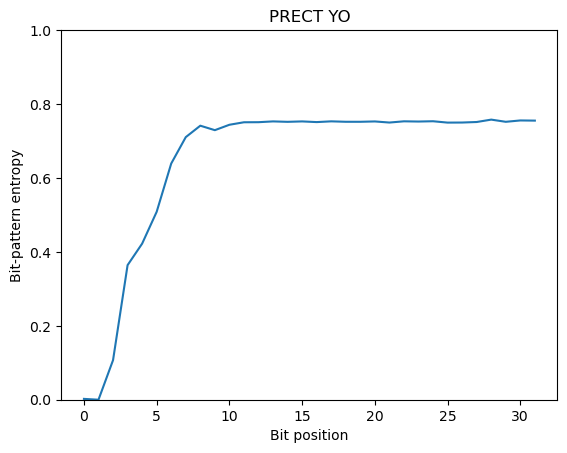

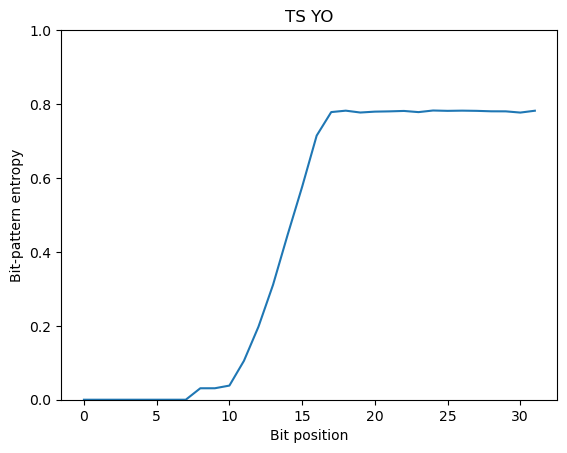

In [4]:
def binary(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))

def get_adj_bits(bit_pos):
    adj_points = [
        [bit_pos[0]-1, bit_pos[1]],
        [bit_pos[0]+1, bit_pos[1]],
        [bit_pos[0], bit_pos[1]-1],
        [bit_pos[0], bit_pos[1]+1]
    ]
    return adj_points

N_BITS = 32

def getbpe(ts_array, x_index, title):
    Hs_all = []

    for y in range(1, ts_array.shape[1]-1):
        for z in range(1, ts_array.shape[1]-1):
            bit_pos = [y, z]
            adj_bits = get_adj_bits(bit_pos)
            bit_strings = []
            for adj_bit in adj_bits:
                y_index, z_index = adj_bit
                value = ts_array[x_index][y_index][z_index]
                value = binary(value)
                bit_strings.append(value)

            Hs = [0] * N_BITS
            i = 0
            for a, b, c, d in zip(*bit_strings):
                val_sum = int(a) + int(b) + int(c) + int(d)
                prob_1 = val_sum / len(adj_bits)
                prob_0 = 1 - prob_1
                if prob_0 == 0 or prob_1 == 0:
                    H = 0
                else:
                    H = -prob_0*log2(prob_0) - prob_1*log2(prob_1)
                Hs[i] = H
                i += 1

            Hs_all.append(Hs)


    Hs_all = np.array(Hs_all)

    result = np.sum(Hs_all, axis=0) / Hs_all.shape[0]

    plt.plot(result)
    plt.title(title)
    plt.ylim(0,1)
    plt.xlabel("Bit position")
    plt.ylabel("Bit-pattern entropy")
    plt.show()


for daily_variable in daily_variables:
    arr = climate_var_arrays[daily_variable]
    for i in range(arr.shape[0]):
        getbpe(arr, i, daily_variable)